In [5]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib
import warnings

In [ ]:
n_list = [13]
n_list = range(9, 50, 1)

In [6]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Parâmetros adicionais
t = 14
d = 90
e = 269
n_list = range(9, 400, 1)
alpha = 0.06  # Mantemos um único valor de alpha


# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)




price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Loop para calcular o RSI para cada valor em 'n_list'
for n in n_list:
    # Dias de alta e dias de baixa
    up_df, down_df = price_data[['Ticker', 'change_in_price']].copy(), price_data[['Ticker', 'change_in_price']].copy()

    # Salvando a diferença para dias de alta
    up_df.loc[up_df['change_in_price'] < 0, 'change_in_price'] = 0

    # Salvando a diferença para dias de baixa
    down_df.loc[down_df['change_in_price'] > 0, 'change_in_price'] = 0

    # Colocando as diferenças do dia de baixa em termos absolutos
    down_df['change_in_price'] = down_df['change_in_price'].abs()

    # Calculando o EWMA (Exponential Weighted Moving Average) para dias de alta e baixa
    ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span=n).mean())
    ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span=n).mean())

    # Calculando o Relative Strength (RS)
    relative_strength = ewma_up / ewma_down

    # Calculando o Relative Strength Index (RSI)
    relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

    # Salvando o RSI como uma nova coluna no dataframe
    price_data[f'RSI_{n}'] = relative_strength_index

    # Salvando colunas auxiliares para verificação (opcional)
    price_data[f'down_days_{n}'] = down_df['change_in_price']
    price_data[f'up_days_{n}'] = up_df['change_in_price']


# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Criação das variáveis low_t e high_t
low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
# Cálculo dos valores mínimos e máximos baseados na janela t
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

# Cálculo do k_percent
k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))


# Armazenando os resultados no DataFrame com nomes dinâmicos
price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent


# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
price_data[f'r_percent_{t}'] = r_percent

# Price Rate of Change
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd



# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()
# Desativa warnings
warnings.filterwarnings("ignore")
price_data.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,RSI_9,down_days_9,up_days_9,RSI_10,down_days_10,up_days_10,RSI_11,down_days_11,up_days_11,RSI_12,down_days_12,up_days_12,RSI_13,down_days_13,up_days_13,RSI_14,down_days_14,up_days_14,RSI_15,down_days_15,up_days_15,RSI_16,down_days_16,up_days_16,RSI_17,down_days_17,up_days_17,RSI_18,down_days_18,up_days_18,RSI_19,down_days_19,up_days_19,RSI_20,down_days_20,up_days_20,RSI_21,down_days_21,up_days_21,RSI_22,down_days_22,up_days_22,RSI_23,down_days_23,up_days_23,RSI_24,down_days_24,up_days_24,RSI_25,down_days_25,up_days_25,RSI_26,down_days_26,up_days_26,RSI_27,down_days_27,up_days_27,RSI_28,down_days_28,up_days_28,RSI_29,down_days_29,up_days_29,RSI_30,down_days_30,up_days_30,RSI_31,down_days_31,up_days_31,RSI_32,down_days_32,up_days_32,RSI_33,down_days_33,up_days_33,RSI_34,down_days_34,up_days_34,RSI_35,down_days_35,up_days_35,RSI_36,down_days_36,up_days_36,RSI_37,down_days_37,up_days_37,RSI_38,down_days_38,up_days_38,RSI_39,down_days_39,up_days_39,RSI_40,down_days_40,up_days_40,RSI_41,down_days_41,up_days_41,RSI_42,down_days_42,up_days_42,RSI_43,down_days_43,up_days_43,RSI_44,down_days_44,up_days_44,RSI_45,down_days_45,up_days_45,RSI_46,down_days_46,up_days_46,RSI_47,down_days_47,up_days_47,RSI_48,down_days_48,up_days_48,RSI_49,down_days_49,up_days_49,RSI_50,down_days_50,up_days_50,RSI_51,down_days_51,up_days_51,RSI_52,down_days_52,up_days_52,RSI_53,down_days_53,up_days_53,RSI_54,down_days_54,up_days_54,RSI_55,down_days_55,up_days_55,RSI_56,down_days_56,up_days_56,RSI_57,down_days_57,up_days_57,RSI_58,down_days_58,up_days_58,RSI_59,down_days_59,up_days_59,RSI_60,down_days_60,up_days_60,RSI_61,down_days_61,up_days_61,RSI_62,down_days_62,up_days_62,RSI_63,down_days_63,up_days_63,RSI_64,down_days_64,up_days_64,RSI_65,down_days_65,up_days_65,RSI_66,down_days_66,up_days_66,RSI_67,down_days_67,up_days_67,RSI_68,down_days_68,up_days_68,RSI_69,down_days_69,up_days_69,RSI_70,down_days_70,up_days_70,RSI_71,down_days_71,up_days_71,RSI_72,down_days_72,up_days_72,RSI_73,down_days_73,up_days_73,RSI_74,down_days_74,up_days_74,RSI_75,down_days_75,up_days_75,RSI_76,down_days_76,up_days_76,RSI_77,down_days_77,up_days_77,RSI_78,down_days_78,up_days_78,RSI_79,down_days_79,up_days_79,RSI_80,down_days_80,up_days_80,RSI_81,down_days_81,up_days_81,RSI_82,down_days_82,up_days_82,RSI_83,down_days_83,up_days_83,RSI_84,down_days_84,up_days_84,RSI_85,down_days_85,up_days_85,RSI_86,down_days_86,up_days_86,RSI_87,down_days_87,up_days_87,RSI_88,down_days_88,up_days_88,RSI_89,down_days_89,up_days_89,RSI_90,down_days_90,up_days_90,RSI_91,down_days_91,up_days_91,RSI_92,down_days_92,up_days_92,RSI_93,down_days_93,up_days_93,RSI_94,down_days_94,up_days_94,RSI_95,down_days_95,up_days_95,RSI_96,down_days_96,up_days_96,RSI_97,down_days_97,up_days_97,RSI_98,down_days_98,up_days_98,RSI_99,down_days_99,up_days_99,RSI_100,down_days_100,up_days_100,RSI_101,down_days_101,up_days_101,RSI_102,down_days_102,up_days_102,RSI_103,down_days_103,up_days_103,RSI_104,down_days_104,up_days_104,RSI_105,down_days_105,up_days_105,RSI_106,down_days_106,up_days_106,RSI_107,down_days_107,up_days_107,RSI_108,down_days_108,up_days_108,RSI_109,down_days_109,up_days_109,RSI_110,down_days_110,up_days_110,RSI_111,down_days_111,up_days_111,RSI_112,down_days_112,up_days_112,RSI_113,down_days_113,up_days_113,RSI_114,down_days_114,up_days_114,RSI_115,down_days_115,up_days_115,RSI_116,down_days_116,up_days_116,RSI_117,down_days_117,up_days_117,RSI_118,down_days_118,up_days_118,RSI_119,down_days_119,up_days_119,RSI_120,down_days_120,up_days_120,RSI_121,down_days_121,up_days_121,RSI_122,down_days_122,up_days_122,RSI_123,down_days_123,up_days_123,RSI_124,down_days_124,up_days_124,RSI_125,down_days_125,up_days_125,RSI_126,down_days_126,up_days_126,RSI_127,down_days_127,up_days_127,RSI_128,down_days_128,up_days_128,RSI_129,down_days_129,up_days_129,RSI_130,down_days_130,up_days_130,RSI_131,down_days_131,up_days_131,RS

In [7]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,RSI_9,down_days_9,up_days_9,RSI_10,down_days_10,up_days_10,RSI_11,down_days_11,up_days_11,RSI_12,down_days_12,up_days_12,RSI_13,down_days_13,up_days_13,RSI_14,down_days_14,up_days_14,RSI_15,down_days_15,up_days_15,RSI_16,down_days_16,up_days_16,RSI_17,down_days_17,up_days_17,RSI_18,down_days_18,up_days_18,RSI_19,down_days_19,up_days_19,RSI_20,down_days_20,up_days_20,RSI_21,down_days_21,up_days_21,RSI_22,down_days_22,up_days_22,RSI_23,down_days_23,up_days_23,RSI_24,down_days_24,up_days_24,RSI_25,down_days_25,up_days_25,RSI_26,down_days_26,up_days_26,RSI_27,down_days_27,up_days_27,RSI_28,down_days_28,up_days_28,RSI_29,down_days_29,up_days_29,RSI_30,down_days_30,up_days_30,RSI_31,down_days_31,up_days_31,RSI_32,down_days_32,up_days_32,RSI_33,down_days_33,up_days_33,RSI_34,down_days_34,up_days_34,RSI_35,down_days_35,up_days_35,RSI_36,down_days_36,up_days_36,RSI_37,down_days_37,up_days_37,RSI_38,down_days_38,up_days_38,RSI_39,down_days_39,up_days_39,RSI_40,down_days_40,up_days_40,RSI_41,down_days_41,up_days_41,RSI_42,down_days_42,up_days_42,RSI_43,down_days_43,up_days_43,RSI_44,down_days_44,up_days_44,RSI_45,down_days_45,up_days_45,RSI_46,down_days_46,up_days_46,RSI_47,down_days_47,up_days_47,RSI_48,down_days_48,up_days_48,RSI_49,down_days_49,up_days_49,RSI_50,down_days_50,up_days_50,RSI_51,down_days_51,up_days_51,RSI_52,down_days_52,up_days_52,RSI_53,down_days_53,up_days_53,RSI_54,down_days_54,up_days_54,RSI_55,down_days_55,up_days_55,RSI_56,down_days_56,up_days_56,RSI_57,down_days_57,up_days_57,RSI_58,down_days_58,up_days_58,RSI_59,down_days_59,up_days_59,RSI_60,down_days_60,up_days_60,RSI_61,down_days_61,up_days_61,RSI_62,down_days_62,up_days_62,RSI_63,down_days_63,up_days_63,RSI_64,down_days_64,up_days_64,RSI_65,down_days_65,up_days_65,RSI_66,down_days_66,up_days_66,RSI_67,down_days_67,up_days_67,RSI_68,down_days_68,up_days_68,RSI_69,down_days_69,up_days_69,RSI_70,down_days_70,up_days_70,RSI_71,down_days_71,up_days_71,RSI_72,down_days_72,up_days_72,RSI_73,down_days_73,up_days_73,RSI_74,down_days_74,up_days_74,RSI_75,down_days_75,up_days_75,RSI_76,down_days_76,up_days_76,RSI_77,down_days_77,up_days_77,RSI_78,down_days_78,up_days_78,RSI_79,down_days_79,up_days_79,RSI_80,down_days_80,up_days_80,RSI_81,down_days_81,up_days_81,RSI_82,down_days_82,up_days_82,RSI_83,down_days_83,up_days_83,RSI_84,down_days_84,up_days_84,RSI_85,down_days_85,up_days_85,RSI_86,down_days_86,up_days_86,RSI_87,down_days_87,up_days_87,RSI_88,down_days_88,up_days_88,RSI_89,down_days_89,up_days_89,RSI_90,down_days_90,up_days_90,RSI_91,down_days_91,up_days_91,RSI_92,down_days_92,up_days_92,RSI_93,down_days_93,up_days_93,RSI_94,down_days_94,up_days_94,RSI_95,down_days_95,up_days_95,RSI_96,down_days_96,up_days_96,RSI_97,down_days_97,up_days_97,RSI_98,down_days_98,up_days_98,RSI_99,down_days_99,up_days_99,RSI_100,down_days_100,up_days_100,RSI_101,down_days_101,up_days_101,RSI_102,down_days_102,up_days_102,RSI_103,down_days_103,up_days_103,RSI_104,down_days_104,up_days_104,RSI_105,down_days_105,up_days_105,RSI_106,down_days_106,up_days_106,RSI_107,down_days_107,up_days_107,RSI_108,down_days_108,up_days_108,RSI_109,down_days_109,up_days_109,RSI_110,down_days_110,up_days_110,RSI_111,down_days_111,up_days_111,RSI_112,down_days_112,up_days_112,RSI_113,down_days_113,up_days_113,RSI_114,down_days_114,up_days_114,RSI_115,down_days_115,up_days_115,RSI_116,down_days_116,up_days_116,RSI_117,down_days_117,up_days_117,RSI_118,down_days_118,up_days_118,RSI_119,down_days_119,up_days_119,RSI_120,down_days_120,up_days_120,RSI_121,down_days_121,up_days_121,RSI_122,down_days_122,up_days_122,RSI_123,down_days_123,up_days_123,RSI_124,down_days_124,up_days_124,RSI_125,down_days_125,up_days_125,RSI_126,down_days_126,up_days_126,RSI_127,down_days_127,up_days_127,RSI_128,down_days_128,up_days_128,RSI_129,down_days_129,up_days_129,RSI_130,down_days_130,up_days_130,RSI_131,down_days_131,up_days_131,RS

n: 9
Fold 1:
 - Correct Prediction (y_test): 61.47%
 - Correct Prediction (Verify): 63.47%
Fold 2:
 - Correct Prediction (y_test): 71.05%
 - Correct Prediction (Verify): 67.93%
Fold 3:
 - Correct Prediction (y_test): 53.79%
 - Correct Prediction (Verify): 54.23%
Fold 4:
 - Correct Prediction (y_test): 70.71%
 - Correct Prediction (Verify): 68.60%
Fold 5:
 - Correct Prediction (y_test): 54.34%
 - Correct Prediction (Verify): 51.22%
Média de acurácia (y_test) para n 9: 62.27%
Média de acurácia (Verify) para n 9: 61.09%
---
n: 10
Fold 1:
 - Correct Prediction (y_test): 63.92%
 - Correct Prediction (Verify): 65.92%
Fold 2:
 - Correct Prediction (y_test): 70.04%
 - Correct Prediction (Verify): 66.93%
Fold 3:
 - Correct Prediction (y_test): 54.34%
 - Correct Prediction (Verify): 54.34%
Fold 4:
 - Correct Prediction (y_test): 71.83%
 - Correct Prediction (Verify): 70.60%
Fold 5:
 - Correct Prediction (y_test): 55.35%
 - Correct Prediction (Verify): 51.56%
Média de acurácia (y_test) para n 10:

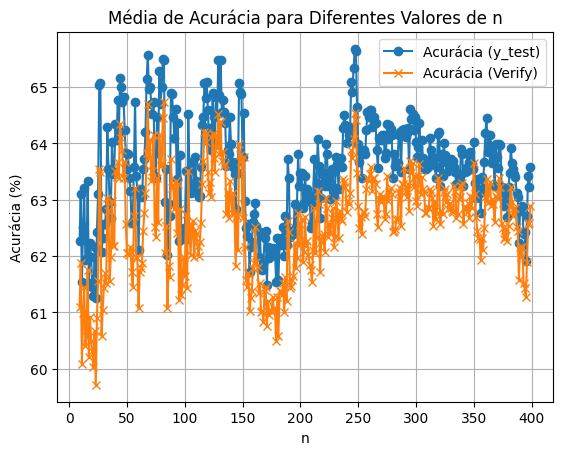

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

# Loop para cada n em n_list e realização de validação cruzada em série temporal
for n in n_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[[f'RSI_{n}',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    'Price_Rate_Of_Change',
                    'MACD',
                    'MACD_EMA',
                    f'On Balance Volume']]
    y = price_data[f'Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)


#### Caso apareça erro float 32

n: 2
Fold 1:
 - Correct Prediction (y_test): 41.99%
 - Correct Prediction (Verify): 41.77%
Fold 2:
 - Correct Prediction (y_test): 46.37%
 - Correct Prediction (Verify): 47.12%
Fold 3:
 - Correct Prediction (y_test): 53.85%
 - Correct Prediction (Verify): 53.31%
Fold 4:
 - Correct Prediction (y_test): 49.04%
 - Correct Prediction (Verify): 49.68%
Fold 5:
 - Correct Prediction (y_test): 49.15%
 - Correct Prediction (Verify): 47.76%
Média de acurácia (y_test) para n 2: 48.08%
Média de acurácia (Verify) para n 2: 47.93%
---
n: 4
Fold 1:
 - Correct Prediction (y_test): 48.16%
 - Correct Prediction (Verify): 47.85%
Fold 2:
 - Correct Prediction (y_test): 47.74%
 - Correct Prediction (Verify): 49.00%
Fold 3:
 - Correct Prediction (y_test): 50.58%
 - Correct Prediction (Verify): 50.68%
Fold 4:
 - Correct Prediction (y_test): 51.52%
 - Correct Prediction (Verify): 51.63%
Fold 5:
 - Correct Prediction (y_test): 46.07%
 - Correct Prediction (Verify): 45.65%
Média de acurácia (y_test) para n 4: 4

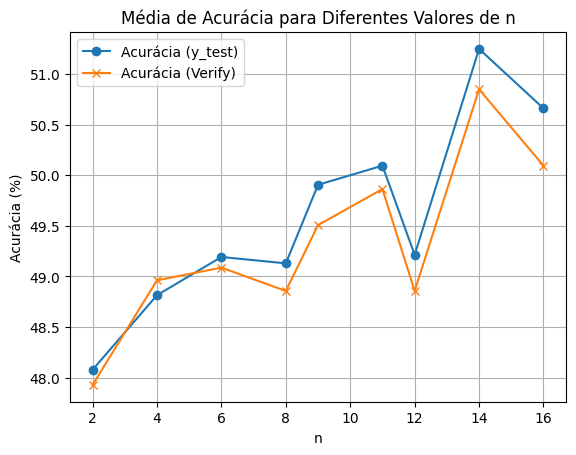

In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound


# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

for n in n_list:
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}_n{n}',
                    f'r_percent_{alpha:.2f}_n{n}',
                    f'Price_Rate_Of_Change_{alpha:.2f}_n{n}',
                    f'MACD_{alpha:.2f}_n{n}',
                    f'MACD_EMA_{alpha:.2f}_n{n}',
                    f'OBV_{alpha:.2f}_n{n}']]
    y = price_data[f'Prediction_{alpha:.2f}_n{n}']
    verify = price_data['Verify']

    # Concatenar e tratar NaN
    data = pd.concat([X, y, verify], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]


    # Converter para float32
    X = X.astype(np.float32)

    # Configurar TimeSeriesSplit e o resto do código
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)